<a href="https://colab.research.google.com/github/Vishsubb/futurecode/blob/main/Comparing_GPT_Microsoft_phi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Before we dive into the project, we need to set up our environment. This involves installing the necessary Python libraries and importing them for use in this notebook.

## Installing Libraries

Run the following cell to install the required libraries.


In [ ]:
#!pip install tiktoken
!pip install transformers datasets --quiet
!pip install scikit-learn --quiet
!pip install openai --quiet
!pip install einops --quiet

## Importing Libraries



In [ ]:
from datasets import get_dataset_config_names, load_dataset
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import random
from typing import List, Dict, Any, Union, Generator, Callable
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
import openai
from getpass import getpass
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import torch
import matplotlib.pyplot as plt
import numpy as np
import json
# import unittest
# from unittest.mock import Mock

torch_device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(torch_device)

# Data for evaluation

## Dataset

Using Financial Phrasebank dataset for this activity. This dataset contains sentences extracted from financial news articles, each labeled with a sentiment category.

## Loading the Dataset

We'll use the Financial Phrasebank dataset available on Hugging Face. we will use the entences_50agree configuration.

## Splitting Data

Load the dataset and then split it into training and test sets.

In [ ]:
# List available configurations
configs = get_dataset_config_names("financial_phrasebank")

# Load the dataset with the 'sentences_50agree' configuration
phrasebank = load_dataset("financial_phrasebank", "sentences_50agree")

# Split the 'train' data into training and test sets
phrasebank_split = phrasebank["train"].train_test_split(test_size=0.1, shuffle=True)

In [ ]:
print (phrasebank)

## Data Exploration

This is how the data is:

In [ ]:
# Randomly pick 5 samples from the training set
random_samples = random.choices(phrasebank_split['train'], k=5)

# Display the samples
for i, sample in enumerate(random_samples):
    print(f"Sample {i+1}:")
    print(f"Text: {sample['sentence']}")
    print(f"Label: {sample['label']} (0: Negative, 1: Neutral, 2: Positive)")
    print("---")


Sample 1:
Text: Of Bavelloni 's and NST 's joint ventures , Bavelloni Tools , completes semiproducts that are produced in Italy into high-quality tools that will be sold under the DiaPol brand .
Label: 1 (0: Negative, 1: Neutral, 2: Positive)
---
Sample 2:
Text: The new agreement , which expands a long-established cooperation between the companies , involves the transfer of certain engineering and documentation functions from Larox to Etteplan .
Label: 2 (0: Negative, 1: Neutral, 2: Positive)
---
Sample 3:
Text: The currency effect had a 3.0 pct , or 20 mln euro ( $ 31.3 mln ) , negative impact on the revenue .
Label: 0 (0: Negative, 1: Neutral, 2: Positive)
---
Sample 4:
Text: Veracel is preparing an appeal in the issue and has asked the court for clarification of the judgement .
Label: 1 (0: Negative, 1: Neutral, 2: Positive)
---
Sample 5:
Text: The authorisation is in force until the end of the next Annual General Meeting and repeals the authorisation to acquire own shares given by 

# Few-Shot Learning

Few-shot learning  to evaluate performance of decoder models like Phi-1.5 and ChatGPT.

This function helps to generae n-shot training records for every test record.

TBD: What is difference between using generator and returning a list

Each example will have the following format:

A one-shot example would look like:
```text
Classify the sentiment (negative, neutral, positive) of the following statement:
[Finnish Raisio ( Diagnostics ) is launching new DNA-based quick tests to ensure the safety of food .]
Reponse: positive
[Export declined by 6 percent to 16.4 million liters]
Reponse:
```
A two-shot example would look like:
```text
Classify the sentiment (negative, neutral, positive) of the following statement:
[Finnish meat company Atria can no longer promise a sufficient amount of domestic beef to its customers .]
Reponse: negative
[Finnish Raisio ( Diagnostics ) is launching new DNA-based quick tests to ensure the safety of food .]
Reponse: positive
[Export declined by 6 percent to 16.4 million liters]
Reponse:
```



In [ ]:
def generate_n_shot_examples(prompt: str,
                             train_set: List[Dict[str, Any]],
                             test_set: List[Dict[str, Any]],
                             n: int) -> Generator[str, None, None]:
    """
    Generates simple n-shot examples.

    This function selects the next 'n' examples from the training set and appends them
    to each query from the test set to create n-shot learning examples. for example if training set contains 100 records and n = 5, one can create
    20 5-shot learning records. but  if there are only 25 records in test, we still can only create 20 5-shot learning records

    Args:
        prompt: The prompt text to be used for the few-shot examples.
        train_set: The training set, a list of dictionaries containing 'sentence' and 'label' keys.
        test_set: The test set, a list of dictionaries containing 'sentence' and 'label' keys.
        n: The number of examples to select from the training set.

    Yields:
        A sample, label representing an n-shot example.
    """

    sentiment_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}



    # Calculate how many samples can be created from the test set length, train set length, and n
    if n != 0 and len(train_set) >= n:
        n_samples = min(len(test_set), len(train_set) //n )
    else:
        n_samples = len(test_set)

    # Create a generator that iterates over the examples
    test_gen = iter(test_set)
    train_gen = iter(train_set)
    # Generate n-shot examples
    for _ in range(n_samples):
        test_sample = next(test_gen)
        n_shot_example = f"{prompt}:\n"

        # Add the n-shot examples to the prompt
        for _ in range(n):
            train_sample = next(train_gen)
            n_shot_example += f"[{train_sample['sentence']}]\nResponse: {sentiment_labels[train_sample['label']]}\n"

        # Add the final test sentence without its label
        n_shot_example += f"[{test_sample['sentence']}]\nResponse:"

        # Use the sentiment_labels dict to convert the numeric (0,1,2) to a text label
        sentiment_label = sentiment_labels[test_sample['label']]

        yield n_shot_example, sentiment_label


# Generate 5-shot examples
n_shot_generator = generate_n_shot_examples("Classify the sentiment (negative, neutral, positive) of the following statement",
                                            phrasebank_split['train'], phrasebank_split['test'], 5)

# Display a couple generated n-shot examples
for _ in range(2):
    sample = next(n_shot_generator)
    print(sample[0])
    print()
    print(sample[1])
    print()

Classify the sentiment (negative, neutral, positive) of the following statement:
[Profit for the period was EUR 15.6 mn compared to EUR 14.1 mn in 2007 .]
Response: positive
[Glaston 's well-known brands are Bavelloni , in pre-processing machines and tools , Tamglass and Uniglass in safety glass machines and Albat + Wirsam in software solutions .]
Response: neutral
[Earlier today , Geberit 's Finnish rival Uponor OYJ cut its full-year sales growth forecast to 6 pct from 10 pct , blaming tough conditions in Germany and the US , as well as currency factors .]
Response: negative
[Vaahto Pulp & Paper , of Finnish Vaahto Group , has been awarded an order to renovate Finnish-Swedish forest industry company Stora Enso 's paperboard machine at the Ingerois Board Mill in Finland .]
Response: positive
[Olli-Pekka Kallasvuo was elected as vice chairman of the Board .]
Response: neutral
[CORPORATE IT UPDATE - ( C ) 1995-2009 M2 COMMUNICATIONS LTD Finnish technology group Teleste Corporation ( OMX 

# Model Overview & Initialization

## Evaluating Decoder Models

Evaluating Phi-1.5 and  GPT-3.A  generic inference function so we can run it in a generic inference loop later.




# Evaluation

Now, let's evaluate models do on the dataset!

In [ ]:
def evaluate_phi_inference(model_name: str, test_dataset: iter, train_set: List[Dict[str, Any]], n: int, prompt: str) -> dict:
    """
    Evaluate the performance of a decoder model on a test dataset, with progress bar and n-shot learning.

    Args:
        model_infer: The model inference function that takes text as input and returns an integer label.
        test_dataset: A generator or iterable containing test samples. Each sample is a dict with keys "label" and "sentence".
        train_set: The training set used for generating n-shot examples.
        n: The number of training examples to use for n-shot learning.
        prompt: The prompt text to be used for the n-shot examples.

    Returns:
        A dictionary containing the average accuracy and F1 score.
    """
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    max_new_tokens = 20

    # Initialize true and predicted labels to empty Python lists
    true_labels = []
    predicted_labels = []

    # This time, we need to use our generator function
    # generate_n_shot_examples()
    # Loaded with the prompt, train and test datasets, and n
    n_shot_gen = generate_n_shot_examples(prompt, train_set, test_dataset, n)


    for input_str, true_label in tqdm(n_shot_gen, total=len(test_dataset), desc="Evaluating"):

        inputs = tokenizer(input_str, return_tensors="pt", return_attention_mask=False)
        input_len = inputs.input_ids.shape[1]
        outputs = model.generate(**inputs,  max_new_tokens=max_new_tokens)
        output_str = tokenizer.batch_decode(outputs[:,input_len:])[0]
        output_str_cleaned = output_str.strip().split()[0]

        # Calculate the predicted label from the n_shot_example
        predicted_label = output_str_cleaned

        # Add the true and predicted labels to the true and predicted labels arrays
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

    # Calculate accuracy and F1 score using sklearn's accuracy_score() and f1_score() functions
    avg_accuracy =accuracy_score(true_labels,predicted_labels)
    avg_f1 = f1_score(true_labels,predicted_labels, average="weighted")


    return {'Average Accuracy': avg_accuracy, 'Average F1 Score': avg_f1}

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
# Let's calculate the evaluation metrics (accuracy and F1 score) for Phi-1.5 (0-shot, 1-shot, 2-shot, and 3-shot!
# Increasing the size of the test set will increase the time required for inference.
num_test_samples = 30
decoder_zero_results = evaluate_phi_inference("microsoft/phi-1_5", phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 0, "Classify the sentiment (negative, neutral, positive) of the following statement")
decoder_one_results = evaluate_phi_inference("microsoft/phi-1_5", phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 1, "Classify the sentiment (negative, neutral, positive) of the following statement")
decoder_two_results = evaluate_phi_inference("microsoft/phi-1_5", phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 2, "Classify the sentiment (negative, neutral, positive) of the following statement")
decoder_three_results = evaluate_phi_inference("microsoft/phi-1_5", phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 3, "Classify the sentiment (negative, neutral, positive) of the following statement")
decoder_four_results = evaluate_phi_inference("microsoft/phi-1_5", phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 4, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 30/30 [00:40<00:00,  1.36s/it]


In [ ]:
# Prepare the ASCII table
header = "| Model Name  | Average Accuracy | Average F1 Score |"
separator = "-" * len(header)

# Print the ASCII table
print(separator)
print(header)
print(separator)
print(f"| Decoder (0-shot)| {decoder_zero_results['Average Accuracy']:<16.4f} | {decoder_zero_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"| Decoder (1-shot)| {decoder_one_results['Average Accuracy']:<16.4f} | {decoder_one_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"| Decoder (2-shot)| {decoder_two_results['Average Accuracy']:<16.4f} | {decoder_two_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"| Decoder (3-shot)| {decoder_three_results['Average Accuracy']:<16.4f} | {decoder_three_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"| Decoder (4-shot)| {decoder_four_results['Average Accuracy']:<16.4f} | {decoder_four_results['Average F1 Score']:<16.4f} |")
print(separator)

-----------------------------------------------------
| Model Name  | Average Accuracy | Average F1 Score |
-----------------------------------------------------
| Decoder (0-shot)| 0.0000           | 0.0000           |
-----------------------------------------------------
| Decoder (1-shot)| 0.5333           | 0.4347           |
-----------------------------------------------------
| Decoder (2-shot)| 0.6000           | 0.5435           |
-----------------------------------------------------
| Decoder (3-shot)| 0.6000           | 0.5716           |
-----------------------------------------------------
| Decoder (4-shot)| 0.5667           | 0.4879           |
-----------------------------------------------------


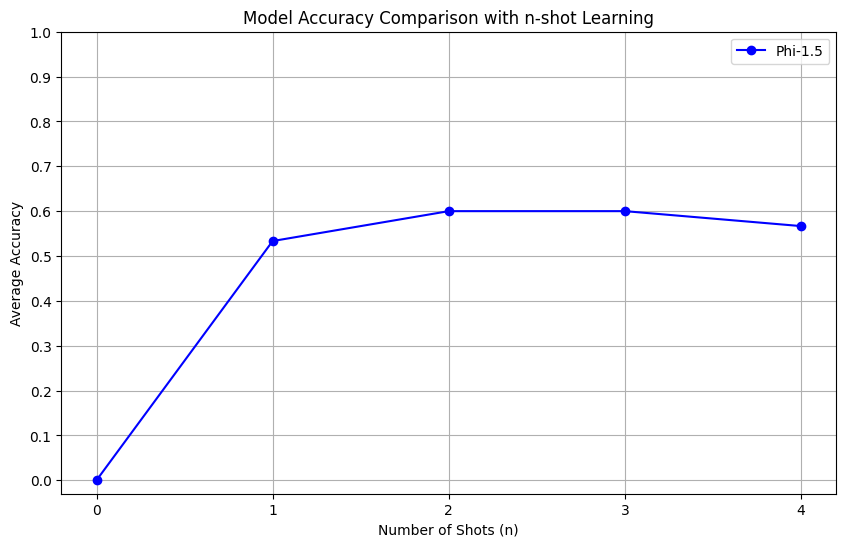

In [ ]:
# Data preparation
n_values = [0, 1, 2, 3,4]  # n-values for Phi-1.5
decoder_accuracies = [
    decoder_zero_results['Average Accuracy'],
    decoder_one_results['Average Accuracy'],
    decoder_two_results['Average Accuracy'],
    decoder_three_results['Average Accuracy'],
    decoder_four_results['Average Accuracy']

]
# roberta_accuracy = roberta_results['Average Accuracy']
# finbert_accuracy = finbert_results['Average Accuracy']

# Plotting
plt.figure(figsize=(10, 6))

# Plot Phi-1.5 accuracies
plt.plot(n_values, decoder_accuracies, marker='o', linestyle='-', label='Phi-1.5', color='b')

# Plot horizontal lines for Roberta and Finbert
# plt.axhline(y=roberta_accuracy, color='r', linestyle='--', label='Roberta')
# plt.axhline(y=finbert_accuracy, color='g', linestyle='--', label='Finbert')

# Adding labels, title, and legend
plt.xlabel('Number of Shots (n)')
plt.ylabel('Average Accuracy')
plt.title('Model Accuracy Comparison with n-shot Learning')
plt.xticks(np.arange(min(n_values), max(n_values)+1, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


# OpenAI API

In [22]:
# Initialize OpenAI API client
if openai.api_key is None:
    # Prompt for the API key
    api_key = getpass("Enter your OpenAI API key: ")

    # Assign the API key to your application-specific variable
    openai.api_key = api_key

Enter your OpenAI API key: ··········


In [29]:
def evaluate_ChatGPT_inference(model_name: str, test_dataset: iter, train_set: List[Dict[str, Any]], n: int, prompt: str) -> dict:

    # Initialize true and predicted labels to empty Python lists
    true_labels = []
    predicted_labels = []

    # This time, we need to use our generator function
    # generate_n_shot_examples()
    # Loaded with the prompt, train and test datasets, and n
    n_shot_gen = generate_n_shot_examples(prompt, train_set, test_dataset, n)

    for input_str, true_label in tqdm(n_shot_gen, total=len(test_dataset), desc="Evaluating"):

        response = openai.chat.completions.create(model=model_name,
            messages=[{"role": "system", "content": "You are a sentiment identtifier."},
                      {"role": "user", "content": input_str}
                      ]    )

        # Extract the response content from the API response
        response_content = response.choices[0].message.content

        # Calculate the predicted label from the n_shot_example
        predicted_label = response_content

        # Add the true and predicted labels to the true and predicted labels arrays
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

    # Calculate accuracy and F1 score using sklearn's accuracy_score() and f1_score() functions
    avg_accuracy =accuracy_score(true_labels,predicted_labels)
    avg_f1 = f1_score(true_labels,predicted_labels, average="weighted")

    return {'Average Accuracy': avg_accuracy, 'Average F1 Score': avg_f1}

In [ ]:
gpt3_0shot_results = evaluate_ChatGPT_inference("gpt-3.5-turbo", phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 0, "Classify the sentiment (negative, neutral, positive) of the following statement")

In [ ]:
# Note that the network connection will slow down these requests
# To save time, let's only look at 20 of the test samples.
# You can increase this to get a more precise value for the model's test set accuracy
num_test_samples = 30

In [31]:
gpt3_0shot_results = evaluate_ChatGPT_inference("gpt-3.5-turbo", phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 0, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 30/30 [00:17<00:00,  1.69it/s]


In [32]:
gpt3_1shot_results = evaluate_ChatGPT_inference("gpt-3.5-turbo", phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 1, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 30/30 [00:19<00:00,  1.54it/s]


In [33]:
gpt3_2shot_results = evaluate_ChatGPT_inference("gpt-3.5-turbo", phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 2, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 30/30 [00:17<00:00,  1.73it/s]


In [34]:
gpt3_3shot_results = evaluate_ChatGPT_inference("gpt-3.5-turbo", phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 3, "Classify the sentiment (negative, neutral, positive) of the following statement")


Evaluating: 100%|██████████| 30/30 [00:14<00:00,  2.12it/s]


In [36]:
gpt3_4shot_results = evaluate_ChatGPT_inference("gpt-3.5-turbo", phrasebank_split['test'].select(range(num_test_samples)), phrasebank_split['train'], 4, "Classify the sentiment (negative, neutral, positive) of the following statement")

Evaluating: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


In [37]:
# Prepare the ASCII table
header = "| Model Name  | Average Accuracy | Average F1 Score |"
separator = "-" * len(header)

# Print the ASCII table
print(separator)
print(header)
print(separator)
print(f"|GPT-3.5 (n=0)| {gpt3_0shot_results['Average Accuracy']:<16.4f} | {gpt3_0shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 (n=1)| {gpt3_1shot_results['Average Accuracy']:<16.4f} | {gpt3_1shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 (n=2)| {gpt3_2shot_results['Average Accuracy']:<16.4f} | {gpt3_2shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 (n=3)| {gpt3_3shot_results['Average Accuracy']:<16.4f} | {gpt3_3shot_results['Average F1 Score']:<16.4f} |")
print(separator)
print(f"|GPT-3.5 (n=3)| {gpt3_4shot_results['Average Accuracy']:<16.4f} | {gpt3_4shot_results['Average F1 Score']:<16.4f} |")
print(separator)

-----------------------------------------------------
| Model Name  | Average Accuracy | Average F1 Score |
-----------------------------------------------------
|GPT-3.5 (n=0)| 0.3000           | 0.4111           |
-----------------------------------------------------
|GPT-3.5 (n=1)| 0.7000           | 0.6925           |
-----------------------------------------------------
|GPT-3.5 (n=2)| 0.5667           | 0.5512           |
-----------------------------------------------------
|GPT-3.5 (n=3)| 0.6333           | 0.6218           |
-----------------------------------------------------
|GPT-3.5 (n=3)| 0.7000           | 0.6925           |
-----------------------------------------------------


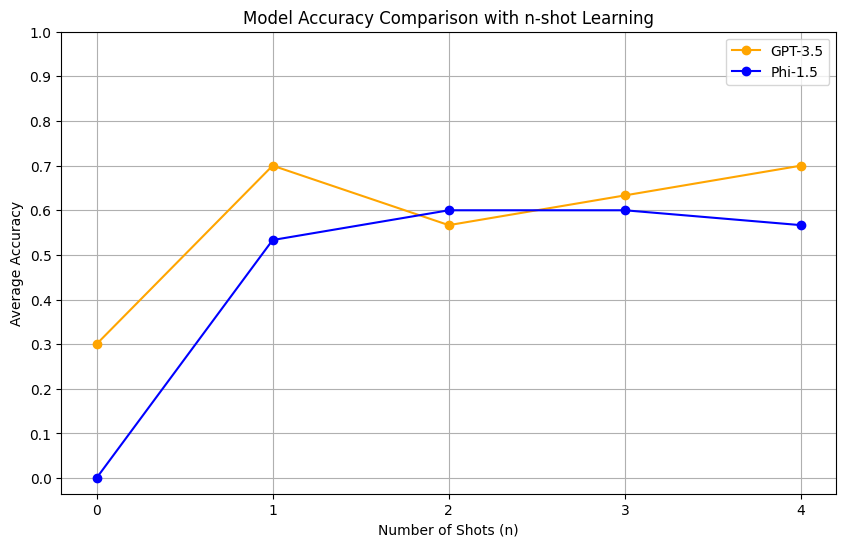

In [39]:
# Data preparation
n_values = [0, 1, 2, 3,4]  # n-values for GPT-3.5
gpt3_accuracies = [
    gpt3_0shot_results['Average Accuracy'],
    gpt3_1shot_results['Average Accuracy'],
    gpt3_2shot_results['Average Accuracy'],
    gpt3_3shot_results['Average Accuracy'],
    gpt3_4shot_results['Average Accuracy']

]
# Plotting
plt.figure(figsize=(10, 6))

# Plot GPT-3.5 accuracies
plt.plot(n_values, gpt3_accuracies, marker='o', linestyle='-', label='GPT-3.5', color='orange')

# Plot Phi-1.5 accuracies
plt.plot(n_values, decoder_accuracies, marker='o', linestyle='-', label='Phi-1.5', color='b')

# Adding labels, title, and legend
plt.xlabel('Number of Shots (n)')
plt.ylabel('Average Accuracy')
plt.title('Model Accuracy Comparison with n-shot Learning')
plt.xticks(np.arange(min(n_values), max(n_values)+1, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend()

# Show the plot
plt.show()
